# Variational AE
In this notebook, we explore VAE with MNIST. VAE is a generative model which learns a continuous latent feature space, which yields stochastic reconstruction from a learned distribution. Kullback-Divergence is used for enforcing the model to not to learn independent concentrated distribution for each class.
### Reference
Intuitive explanation
https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf
Constructing VAE using keras
https://blog.keras.io/building-autoencoders-in-keras.html

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


In [17]:
def variational_ae(n_hidden, input_dim):

    initializer = tf.variance_scaling_initializer()
    X_ph = tf.placeholder(tf.float32, shape=(None, input_dim))
    # ----- Encoder -----
    # first hidden layer
    W_1 = tf.Variable(initializer([input_dim, 128]), dtype=tf.float32)
    b_1 = tf.Variable(tf.zeros(128), dtype=tf.float32)
    z_1 = tf.matmul(X_ph, W_1) + b_1
    a_1 = tf.nn.relu(z_1)
    
    # probabilistic encoding layer
    W_mu = tf.Variable(initializer([128, n_hidden]), dtype=tf.float32)
    b_mu = tf.Variable(tf.zeros(n_hidden), dtype=tf.float32)
    latent_mu = tf.matmul(a_1, W_mu) + b_mu
    W_sig = tf.Variable(initializer([128, n_hidden]), dtype=tf.float32)
    b_sig = tf.Variable(tf.zeros(n_hidden), dtype=tf.float32)
    log_latent_sig = tf.matmul(a_1, W_sig) + b_sig
    
    eps = tf.random_normal(shape=tf.shape(log_latent_sig), mean=0, 
                           stddev=1, dtype=tf.float32)
    encoded = latent_mu + tf.sqrt(tf.exp(log_latent_sig)) * eps
    
    # ----- Decoder -----
    W_2 = tf.Variable(initializer([n_hidden, 128]), dtype=tf.float32)
    b_2 = tf.Variable(tf.zeros(128), dtype=tf.float32)
    z_2 = tf.matmul(encoded, W_2) + b_2
    a_2 = tf.nn.relu(z_2)
    W_3 = tf.Variable(initializer([128, input_dim]), dtype=tf.float32)
    b_3 = tf.Variable(tf.zeros(input_dim), dtype=tf.float32)
    z_3 = tf.matmul(a_2, W_3) + b_3
    decoded = tf.nn.sigmoid(z_3)

    # reconstruction loss
    cross_entropy = -tf.reduce_sum(X_ph * tf.log(1e-10+decoded) + 
                                (1-X_ph) * tf.log(1e-10+1-decoded), axis=1)
    recon_loss = tf.reduce_mean(cross_entropy)
    # KL loss
    kullback_div = -0.5 * tf.reduce_sum(1 + log_latent_sig - 
                                        tf.square(latent_mu) - 
                                        tf.exp(log_latent_sig), axis=1)
    kl_loss = tf.reduce_mean(kullback_div)
    
    
    loss = recon_loss + kl_loss    
    optimizer = tf.train.AdamOptimizer(0.01)
    train_op = optimizer.minimize(loss)
    
    return X_ph, encoded, decoded, loss, train_op

1/20 finished, training loss: 160.06882967631023
2/20 finished, training loss: 126.91384206136068
3/20 finished, training loss: 122.44288508097331
4/20 finished, training loss: 120.49658905029297
5/20 finished, training loss: 119.78004013061523
6/20 finished, training loss: 118.75830055236817
7/20 finished, training loss: 118.30985799153646
8/20 finished, training loss: 117.83199071248373
9/20 finished, training loss: 117.39675702412923
10/20 finished, training loss: 117.00451347351074
11/20 finished, training loss: 117.2766724395752
12/20 finished, training loss: 116.6376304880778
13/20 finished, training loss: 116.52812726338705
14/20 finished, training loss: 116.34077288309733
15/20 finished, training loss: 116.08632227579753
16/20 finished, training loss: 116.25670143127441
17/20 finished, training loss: 115.86606341044109
18/20 finished, training loss: 115.90763763427735
19/20 finished, training loss: 115.68103307088217
20/20 finished, training loss: 115.72324165344239


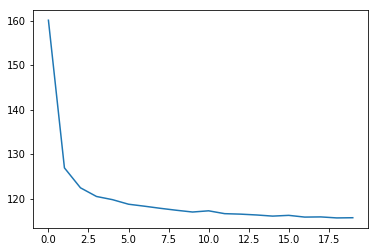

In [19]:
X_ph, encoded, decoded, loss, train_op, eps = variational_ae(32, 784)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
training_loss = []
n_batches = 300 # that will lead to a batch size of 200
batches = np.split(x_train, n_batches)
np.random.shuffle(batches)
n_epoches = 20

for epoch in range(n_epoches):
    batch_loss = 0
    for b in batches:
        _, losses = sess.run([train_op, loss], feed_dict={X_ph: b})
        batch_loss += losses
    training_loss.append(batch_loss/n_batches)
    print(f'{epoch+1}/{n_epoches} finished, training loss: {batch_loss/n_batches}')
plt.plot(training_loss)
plt.show()

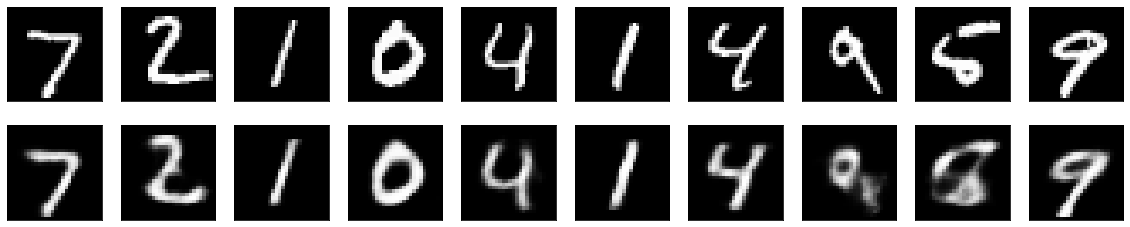

In [20]:
decoded_imgs = sess.run(decoded, feed_dict={X_ph: x_test})
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

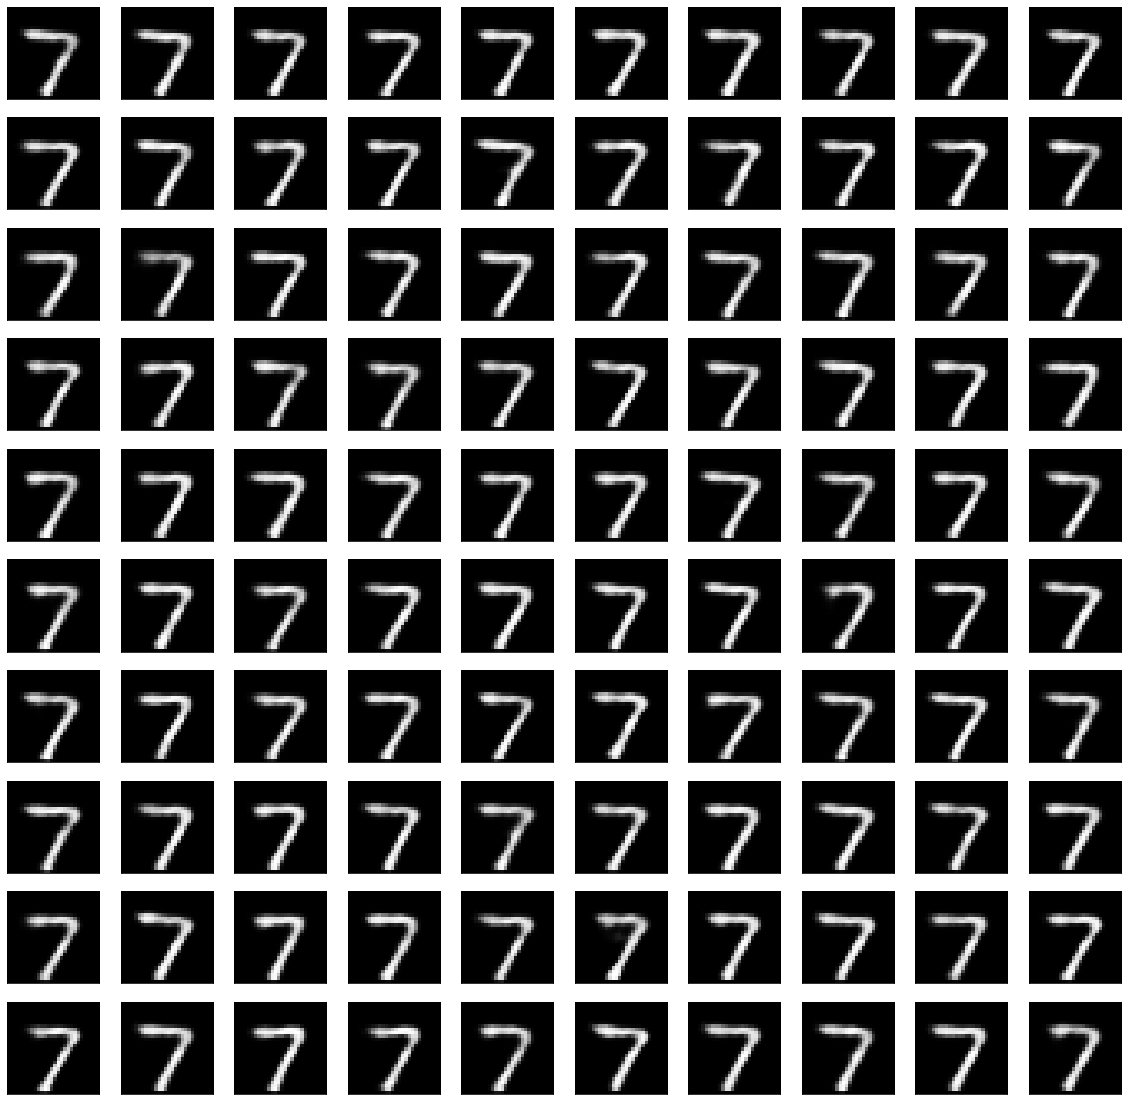

In [45]:
x_2gen = np.tile(x_test[0], [100, 1])
x_generated = sess.run(decoded, feed_dict={X_ph: x_2gen})


plt.figure(figsize=(20, 20))
for i in range(10):
    for j in range(10):
        ax = plt.subplot(10, 10, i*10 + j + 1)
        plt.imshow(x_generated[i*10 + j].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
plt.show()